INSPER - Big Data e Computação em Nuvem

# Projeto Final

- Guilherme Fregulia
- Rodrigo França
- Tamara Alves
- Vinicius Vargas

In [1]:
!pip install -q holidays

In [2]:
! pip install -q pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 16.4 MB/s eta 0:00:00


## Importando Dados

No código abaixo criamos a sessão SparK e fazemos a importação e tratamento inicial do nosso conjunto de dados.

In [3]:
### Setup de Libs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import pyspark.sql.functions as f
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import date, datetime
import datetime
from datetime import date
import holidays
import pandas as pd

In [4]:
### Criar a sessao do Spark
from pyspark.sql import SparkSession
spark = SparkSession \
            .builder \
            .master("local[4]") \
            .appName("nyc_pisloteros_de_los_datos>") \
            .config("spark.driver.memory", "10g") \
            .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.4,com.microsoft.azure:azure-storage:8.6.6") \
            .getOrCreate()

In [5]:
### Credenciais para chamada de dados
STORAGE_ACCOUNT = 'dlspadseastusprod'
CONTAINER = 'big-data-comp-nuvem'
FOLDER = 'airline-delay'
TOKEN = 'lSuH4ZI9BhOFEhCF/7ZQbrpPBIhgtLcPDfXjJ8lMxQZjaADW4p6tcmiZGDX9u05o7FqSE2t9d2RD+ASt0YFG8g=='

spark.conf.set("fs.azure.account.key." + STORAGE_ACCOUNT + ".blob.core.windows.net", TOKEN)

In [6]:
### Principais configs do Spark
config = spark.sparkContext._jsc.hadoopConfiguration()
config.set("fs.azure.account.key." + STORAGE_ACCOUNT + ".blob.core.windows.net", TOKEN)
sc = spark.sparkContext

In [7]:
### Definição formal do Schema
labels =(
    ('FL_DATE', DateType()),
    ('OP_CARRIER', StringType()),
    ('OP_CARRIER_FL_NUM', IntegerType()),
    ('ORIGIN', StringType()),
    ('DEST', StringType()),
    ('CRS_DEP_TIME', FloatType()),
    ('DEP_TIME', FloatType()),
    ('DEP_DELAY', FloatType()),
    ('TAXI_OUT', FloatType()),
    ('WHEELS_OFF', FloatType()),
    ('WHEELS_ON', FloatType()),
    ('TAXI_IN', FloatType()),
    ('CRS_ARR_TIME', FloatType()),
    ('ARR_TIME', FloatType()),
    ('ARR_DELAY', FloatType()),
    ('CANCELLED', FloatType()),
    ('CANCELLATION_CODE', StringType()),
    ('DIVERTED', FloatType()),
    ('CRS_ELAPSED_TIME', FloatType()),
    ('ACTUAL_ELAPSED_TIME', FloatType()),
    ('AIR_TIME', FloatType()),
    ('DISTANCE', FloatType()),
    ('CARRIER_DELAY', FloatType()),
    ('WEATHER_DELAY', FloatType()),
    ('NAS_DELAY', FloatType()),
    ('SECURITY_DELAY', FloatType()),
    ('LATE_AIRCRAFT_DELAY', FloatType())
)

my_schema = StructType([StructField(x[0], x[1], True) for x in labels])

In [8]:
### Leitura dos dados
df09 = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2009.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, schema = my_schema)

df10 = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2010.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, schema = my_schema)

df11 = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2011.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, schema = my_schema)

df12 = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2012.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, schema = my_schema)

df13 = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2013.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, schema = my_schema)

df14 = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2014.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, schema = my_schema)

df15 = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2015.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, schema = my_schema)

df16 = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2016.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, schema = my_schema)

df17 = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2017.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, schema = my_schema)

df18 = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2018.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, schema = my_schema)

In [9]:
### criando uma lista com todos os nossos data frames
dfs = [df09, df10, df11, df12, df13, df14, df15, df16, df17, df18]

### Unindo os data frames
merged_df = reduce(lambda x, y: x.union(y), dfs)

## Análise Exploratória

É esperado que dias com muitos voos ocasionem mais atrasos. Por sua vez, espera-se que em datas festivas, finais de semanas e feriados o trânsito em aeroportos seja substancialmente mais alto.

Abaixo, fazemos uma análise exploratória dos dados a fim de averiguar esta hipótese.

In [10]:
### Chamada de Feriados Americanos
us_holidays = holidays.US()

### Definição dos anos em interesse
feriados = holidays.US(
    [
        2009,
        2010,
        2011,
        2012,
        2013,
        2014,
        2015,
        2016,
        2017,
        2018
  ]
)

### Lasso para obtenção dos dados
dct = {k:[v] for k,v in feriados.items()}

### Pivot dos dados
feriados_US = (
    pd.DataFrame(dct) 
    .T
    .rename_axis('Data')
    .reset_index()
)
feriados_US = feriados_US['Data']

### Criação do objeto para salvar os dados
dias_anteriores = []

### Lasso para adição dos feriádos ao nosso Dataset
for i in feriados_US:
    dias_anteriores.append(i - datetime.timedelta(days=1))


feriados_US  = feriados_US.to_list()
dias_feriados = dias_anteriores + feriados_US
dias_feriados.sort()

In [11]:
### Adição dos feriádos à base principal de dados
merged_df = (
    merged_df
    .withColumn("is_holiday", f.when(f.col("FL_DATE").isin(dias_feriados),1).otherwise(0))
)

### Filtrando apenas os dados de 2010 - por limitação de processamento
df10_adj = merged_df.filter(year(merged_df.FL_DATE) == 2010)

merged_df.cache()
df10_adj.cache()

DataFrame[FL_DATE: date, OP_CARRIER: string, OP_CARRIER_FL_NUM: int, ORIGIN: string, DEST: string, CRS_DEP_TIME: float, DEP_TIME: float, DEP_DELAY: float, TAXI_OUT: float, WHEELS_OFF: float, WHEELS_ON: float, TAXI_IN: float, CRS_ARR_TIME: float, ARR_TIME: float, ARR_DELAY: float, CANCELLED: float, CANCELLATION_CODE: string, DIVERTED: float, CRS_ELAPSED_TIME: float, ACTUAL_ELAPSED_TIME: float, AIR_TIME: float, DISTANCE: float, CARRIER_DELAY: float, WEATHER_DELAY: float, NAS_DELAY: float, SECURITY_DELAY: float, LATE_AIRCRAFT_DELAY: float, is_holiday: int]

In [12]:
merged_df.limit(5).toPandas().fillna(0)

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,is_holiday
0,2009-01-01,XE,1204,DCA,EWR,1100.0,1058.0,-2.0,18.0,1116.0,...,62.0,68.0,42.0,199.0,0.0,0.0,0.0,0.0,0.0,1
1,2009-01-01,XE,1206,EWR,IAD,1510.0,1509.0,-1.0,28.0,1537.0,...,82.0,75.0,43.0,213.0,0.0,0.0,0.0,0.0,0.0,1
2,2009-01-01,XE,1207,EWR,DCA,1100.0,1059.0,-1.0,20.0,1119.0,...,70.0,62.0,36.0,199.0,0.0,0.0,0.0,0.0,0.0,1
3,2009-01-01,XE,1208,DCA,EWR,1240.0,1249.0,9.0,10.0,1259.0,...,77.0,56.0,37.0,199.0,0.0,0.0,0.0,0.0,0.0,1
4,2009-01-01,XE,1209,IAD,EWR,1715.0,1705.0,-10.0,24.0,1729.0,...,105.0,77.0,40.0,213.0,0.0,0.0,0.0,0.0,0.0,1


In [13]:
### Top 10 companhias aereas com mais voos entre 2009 e 2010
top_10_airlines = (
    merged_df
    .groupBy('OP_CARRIER')
    .count()
    .orderBy(desc('count'))
    .head(10)
)

In [14]:
### Group the flights by airline and count the number of flights per airline
airline_counts = merged_df.groupBy('OP_CARRIER').count()

### Sort the airlines by the number of flights in descending order
airline_counts = airline_counts.orderBy(desc('count'))

### Take the top 10 most common airlines
top_10_airlines = airline_counts.head(10)

### Print the top 10 airlines by number of flights
print(top_10_airlines)

top_10_air = merged_df.groupBy('OP_CARRIER').count()

[Row(OP_CARRIER='WN', count=12096540), Row(OP_CARRIER='DL', count=7841880), Row(OP_CARRIER='AA', count=6682161), Row(OP_CARRIER='OO', count=6263052), Row(OP_CARRIER='UA', count=4826658), Row(OP_CARRIER='EV', count=4726445), Row(OP_CARRIER='MQ', count=3216260), Row(OP_CARRIER='US', count=2657286), Row(OP_CARRIER='B6', count=2483969), Row(OP_CARRIER='AS', count=1660539)]


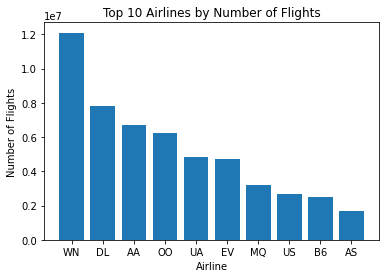

In [15]:
### Lasso
airline_codes = [row[0] for row in top_10_airlines]
flight_counts = [row[1] for row in top_10_airlines]

### Plot o top 10 por números de voos
plt.bar(airline_codes, flight_counts)
plt.title('Top 10 Airlines by Number of Flights')
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.show()

In [14]:
### Rota e empresa aerea com maior número de atraso ao longo de todos os anos.

### ETL criando nova coluna e removendo variáveis
df100 = (
    merged_df
    .withColumn('ATRASO', f.when((merged_df.ARR_DELAY > 0) | (merged_df.DEP_DELAY > 0), 1).otherwise(0))
    .drop(
        'FL_DATE',
        'CRS_DEP_TIME',
        'DEP_TIME',
        'DEP_DELAY',
        'TAXI_OUT',
        'WHEELS_OFF',
        'CRS_ELAPSED_TIME',
        'ACTUAL_ELAPSED_TIME',
        'AIR_TIME','DISTANCE',
        'CARRIER_DELAY',
        'WEATHER_DELAY',
        'NAS_DELAY',
        'SECURITY_DELAY',
        'LATE_AIRCRAFT_DELAY',
        'is_holiday'
    )
)

### Filtro de atrasos
df110 = (
    df100
    .filter(df100["ATRASO"] == 1)
    .select(
        'ORIGIN',
        'DEST',
        'OP_CARRIER_FL_NUM',
        'OP_CARRIER'
    )
)

### Group the flights by airline and count the number of flights per airline
fl_num_counts = df110.groupBy(['ORIGIN', 'DEST','OP_CARRIER']).count()

### Sort the airlines by the number of flights in descending order
fl_num_counts = fl_num_counts.orderBy(desc('count'))

### Take the top 10 most common airlines
top_10_fl_num = fl_num_counts.head(10)

fl_num_counts.limit(10).toPandas()

,ORIGIN,DEST,OP_CARRIER,count
0,DAL,HOU,WN,45886
1,HOU,DAL,WN,43468
2,DFW,LAX,AA,36105
3,OGG,HNL,HA,34417
4,DFW,ORD,AA,31330
5,HNL,OGG,HA,30630
6,ORD,DFW,AA,29785
7,OAK,LAX,WN,29491
8,ATL,LGA,DL,29268
9,ATL,MCO,DL,28551


In [16]:
### Agregação pelas variáveis Origin & Destino
airport_counts = merged_df.groupBy(['ORIGIN', 'DEST']).count()

# Sort the airlines by the number of flights in descending order
airport_counts = airport_counts.orderBy(desc('count'))

# Take the top 10 most common airlines
top_10_airports = airport_counts.head(10)

# Print the top 10 airlines by number of flights
print(top_10_airports)

[Row(ORIGIN='SFO', DEST='LAX', count=148348), Row(ORIGIN='LAX', DEST='SFO', count=147011), Row(ORIGIN='JFK', DEST='LAX', count=113637), Row(ORIGIN='LAX', DEST='JFK', count=113599), Row(ORIGIN='LAX', DEST='LAS', count=112157), Row(ORIGIN='LAS', DEST='LAX', count=111945), Row(ORIGIN='OGG', DEST='HNL', count=108778), Row(ORIGIN='HNL', DEST='OGG', count=107502), Row(ORIGIN='LGA', DEST='ORD', count=104700), Row(ORIGIN='ORD', DEST='LGA', count=103318)]


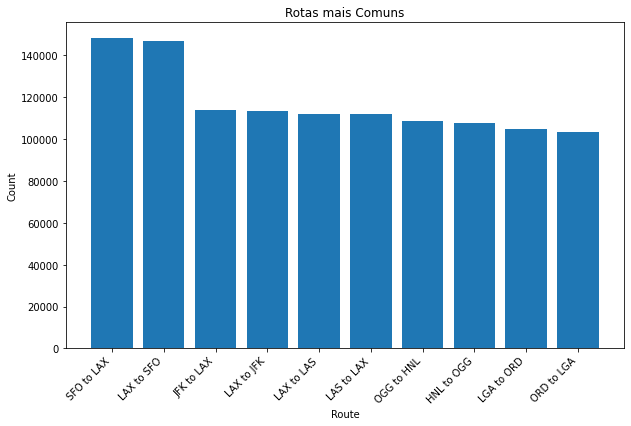

In [17]:
### Plot de Rotas mais Comuns
airport_codes = [row[0:1] for row in top_10_airports]
flight_num = [row[2] for row in top_10_airports]

x = [f"{d[0]} to {d[1]}" for d in top_10_airports]
y = [d[2] for d in top_10_airports]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, y)
ax.set_xlabel('Route')
ax.set_ylabel('Count')
ax.set_title('Rotas mais Comuns')
plt.xticks(rotation=45, ha='right')
plt.show()

## Pre-processamento dados

Nesta seção fazemos o pre-processamento dos dados antes de treinarmos os modelos de predição.

In [18]:
model_df = df10_adj

In [21]:
### ETL transformando o dataframe original na base pronta para modelagem
model_df1 = (
    model_df
    .withColumn('ATRASO', when(model_df.ARR_DELAY > 0, 1).otherwise(0))
    .withColumn('WEEK_NUMBER', weekofyear(model_df.FL_DATE))
    .withColumn('DAY_OF_WEEK', dayofweek(model_df.FL_DATE))
    .withColumn('PROP_DEP_DELAY', model_df.DEP_DELAY / (model_df.CRS_ARR_TIME - model_df.CRS_DEP_TIME))
    .filter(model_df.CANCELLED == 0)
    .drop(
        'ACTUAL_ELAPSED_TIME',
        'ARR_TIME',
        'ARR_DELAY',
        'WHEELS_ON',
        'FL_DATE',
        'OP_CARRIER_FL_NUM',
        'CANCELLED',
        'CANCELLATION_CODE',
        'CARRIER_DELAY',
        'WEATHER_DELAY',
        'NAS_DELAY',
        'SECURITY_DELAY',
        'TAXI_IN',
        'LATE_AIRCRAFT_DELAY'
    )
    .fillna(0)
)

model_df1.printSchema()

root
 |-- OP_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: float (nullable = false)
 |-- DEP_TIME: float (nullable = false)
 |-- DEP_DELAY: float (nullable = false)
 |-- TAXI_OUT: float (nullable = false)
 |-- WHEELS_OFF: float (nullable = false)
 |-- CRS_ARR_TIME: float (nullable = false)
 |-- DIVERTED: float (nullable = false)
 |-- CRS_ELAPSED_TIME: float (nullable = false)
 |-- AIR_TIME: float (nullable = false)
 |-- DISTANCE: float (nullable = false)
 |-- is_holiday: integer (nullable = false)
 |-- ATRASO: integer (nullable = false)
 |-- WEEK_NUMBER: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- PROP_DEP_DELAY: double (nullable = false)



Separando os dados entre treino e teste

In [22]:
train_df, test_df = model_df1.randomSplit([0.6, 0.4], seed=42)
toy_df = test_df.sample(False, 0.01, seed=42)

In [23]:
print("Train set count: ", train_df.count())
print("Test set count:", test_df.count())
print("Toy df count:", toy_df.count())

Train set count:  3805102
Test set count: 2531760
Toy df count: 25308


In [24]:
train_df.limit(10).toPandas()

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,CRS_ARR_TIME,DIVERTED,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,is_holiday,ATRASO,WEEK_NUMBER,DAY_OF_WEEK,PROP_DEP_DELAY
0,9E,ABE,DTW,600.0,550.0,-10.0,37.0,627.0,746.0,0.0,106.0,95.0,424.0,0,1,5,4,-0.068493
1,9E,ABE,DTW,600.0,552.0,-8.0,20.0,612.0,746.0,0.0,106.0,81.0,424.0,0,0,1,5,-0.054795
2,9E,ABE,DTW,600.0,554.0,-6.0,29.0,623.0,746.0,0.0,106.0,78.0,424.0,0,1,5,6,-0.041096
3,9E,ABE,DTW,600.0,555.0,-5.0,20.0,615.0,746.0,0.0,106.0,73.0,424.0,0,0,3,7,-0.034247
4,9E,ABE,DTW,600.0,555.0,-5.0,21.0,616.0,746.0,0.0,106.0,77.0,424.0,0,0,1,3,-0.034247
5,9E,ABE,DTW,600.0,555.0,-5.0,25.0,620.0,746.0,0.0,106.0,81.0,424.0,0,1,1,1,-0.034247
6,9E,ABE,DTW,600.0,555.0,-5.0,42.0,637.0,746.0,0.0,106.0,87.0,424.0,0,1,3,4,-0.034247
7,9E,ABE,DTW,600.0,556.0,-4.0,9.0,605.0,746.0,0.0,106.0,67.0,424.0,0,0,2,3,-0.027397
8,9E,ABE,DTW,600.0,557.0,-3.0,13.0,610.0,746.0,0.0,106.0,70.0,424.0,0,0,1,7,-0.020548
9,9E,ABE,DTW,600.0,557.0,-3.0,21.0,618.0,746.0,0.0,106.0,85.0,424.0,0,1,2,2,-0.020548


Tratando variáveis categóricas com One Hot Enconder

In [25]:
### Seleção de variáveis categoricas
cat_feats = [
    'OP_CARRIER',
    'ORIGIN',
    'DEST',
]

### Lasso selecionando variáveis
indexOutputCols = [x + "Index" for x in cat_feats]
oheOutputCols = [x + "OHE" for x in cat_feats]

stringIndexer = StringIndexer(
    inputCols = cat_feats,
    outputCols = indexOutputCols,
    handleInvalid = "skip"
)

### One Hot Enconding
oheEncoder = OneHotEncoder(
    inputCols = indexOutputCols,
    outputCols = oheOutputCols
)

Tratando variáveis numéricas

In [26]:
### Seleção de variáveis numéricas
num_feats = [
    'CRS_DEP_TIME',
    'DEP_TIME',
    'DEP_DELAY',
    'TAXI_OUT',
    'WHEELS_OFF',
    'WEEK_NUMBER',
    'DAY_OF_WEEK',
    'CRS_ARR_TIME',
    'DIVERTED',
    'CRS_ELAPSED_TIME',
    'AIR_TIME',
    'DISTANCE',
    'PROP_DEP_DELAY',
    'is_holiday'
]

### Vetorização
numVecAssembler = VectorAssembler(inputCols = num_feats, outputCol = "features", handleInvalid='skip')

### Scaling das variáveis numéricas
stdScaler = StandardScaler(inputCol='features', outputCol='features_scaled')

In [27]:
### União de variáveis categoricas e numéricas - Ambas tratadas
assemblerInputs = oheOutputCols + ['features_scaled']

vecAssembler = VectorAssembler(inputCols = assemblerInputs, outputCol = "features_vector")

In [28]:
stages = [stringIndexer, oheEncoder, numVecAssembler, stdScaler, vecAssembler]

In [29]:
transform_pipeline =  Pipeline(stages=stages)
fitted_transformer = transform_pipeline.fit(train_df)
transformed_train_df = fitted_transformer.transform(train_df)

In [30]:
train_df.cache()

DataFrame[OP_CARRIER: string, ORIGIN: string, DEST: string, CRS_DEP_TIME: float, DEP_TIME: float, DEP_DELAY: float, TAXI_OUT: float, WHEELS_OFF: float, CRS_ARR_TIME: float, DIVERTED: float, CRS_ELAPSED_TIME: float, AIR_TIME: float, DISTANCE: float, is_holiday: int, ATRASO: int, WEEK_NUMBER: int, DAY_OF_WEEK: int, PROP_DEP_DELAY: double]

## Modelagem

In [31]:
### Setup de libs para modelagem
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [32]:
### Treino de uma árvore de devisão
labelCol = 'ATRASO'

### Seleção e execução do Classificador
dt = DecisionTreeClassifier(
    labelCol=labelCol,
    featuresCol='features_vector',
    impurity='gini'
)

### União do modelo aos Stages
pipe_stages = stages + [dt]

### Run do pipeline
pipe_dt_dt = Pipeline(stages=pipe_stages)

### Fit do modelo
fitted_pipe_dt = pipe_dt_dt.fit(train_df)

### Predição usando modelo treinado na base de teste
preds = fitted_pipe_dt.transform(test_df)

### Etapa de avaliação de modelo
evaluator = MulticlassClassificationEvaluator(
    labelCol=labelCol,
    predictionCol='prediction',
    metricName='accuracy'
)

### Avaliação da acurácia do modelo treinado
evaluator = MulticlassClassificationEvaluator(labelCol=labelCol, metricName='accuracy')
accuracy = evaluator.evaluate(preds)

### Print do resultado
print('Accuracy of DecisionTree model:', accuracy)

Accuracy of DecisionTree model: 0.8304065156254937


In [33]:
### Treino de uma Regressão Logística
lr = LogisticRegression(
    maxIter=100,
    regParam=0.3,
    elasticNetParam=0.1,
    featuresCol='features_vector',
    family = 'binomial',
    labelCol=labelCol
)

### União do modelo aos Stages
pipe_stages = stages + [lr]

### Run do pipeline
pipe_dt_lr = Pipeline(stages=pipe_stages)

### Fit do modelo
fitted_pipe_lr = pipe_dt_lr.fit(train_df)

### Predição usando modelo treinado na base de teste
preds = fitted_pipe_lr.transform(test_df)

### Etapa de avaliação de modelo
evaluator = MulticlassClassificationEvaluator(
    labelCol=labelCol,
    predictionCol='prediction',
    metricName='accuracy'
)

### Avaliação da acurácia do modelo treinado
evaluator = MulticlassClassificationEvaluator(labelCol=labelCol, metricName='accuracy')
accuracy = evaluator.evaluate(preds)

### Print do resultado
print('Accuracy of Logistic Regression model:', accuracy)

Accuracy of Logistic Regression model: 0.7025263058109773


In [34]:
### Treino de uma Floresta de Decisão
rf = RandomForestClassifier(
    labelCol=labelCol,
    featuresCol='features_vector',
    numTrees=100
)

### União do modelo aos Stages
pipe_stages = stages + [rf]

### Run do pipeline
pipe_dt_rf = Pipeline(stages=pipe_stages)

### Fit do modelo
fitted_pipe_rf = pipe_dt_rf.fit(train_df)

### Predição usando modelo treinado na base de teste
preds = fitted_pipe_rf.transform(test_df)

### Etapa de avaliação de modelo
evaluator = MulticlassClassificationEvaluator(
    labelCol=labelCol,
    predictionCol='prediction',
    metricName='accuracy'
)

### Avaliação da acurácia do modelo treinado
evaluator = MulticlassClassificationEvaluator(labelCol=labelCol, metricName='accuracy')
accuracy = evaluator.evaluate(preds)

### Print do resultado
print('Accuracy of Random Forest Model:', accuracy)

Accuracy of Random Forest Model: 0.8005675893449616


In [35]:
### Treino de um Gradiente Boosting
gbt = GBTClassifier(
    labelCol=labelCol,
    featuresCol="features_vector",
    maxIter=10
)

### União do modelo aos Stages
pipe_stages = stages + [gbt]

### Run do pipeline
pipe_dt_gbt = Pipeline(stages=pipe_stages)

### Fit do modelo
fitted_pipe_gbt = pipe_dt_gbt.fit(train_df)

### Predição usando modelo treinado na base de teste
preds = fitted_pipe_gbt.transform(test_df)

### Etapa de avaliação de modelo
evaluator = MulticlassClassificationEvaluator(
    labelCol=labelCol,
    predictionCol='prediction',
    metricName='accuracy'
)

### Avaliação da acurácia do modelo treinado
evaluator = MulticlassClassificationEvaluator(labelCol=labelCol, metricName='accuracy')
accuracy = evaluator.evaluate(preds)

### Print do resultado
print('Accuracy of Gradient Boosting Model:', accuracy)

Accuracy of Gradient Boosting Model: 0.8417575125604323


In [37]:
### Execução do teste do modelo treinado na base de teste

### Utilização do modelo campeão - GBM Model
preds = fitted_pipe_rf.transform(test_df)

### Etapa de avaliação de modelo
evaluator = MulticlassClassificationEvaluator(
    labelCol=labelCol,
    predictionCol='prediction',
    metricName='accuracy'
)

### Avaliação da acurácia do modelo treinado
evaluator = MulticlassClassificationEvaluator(labelCol=labelCol, metricName='accuracy')
accuracy = evaluator.evaluate(preds)

### Print do resultado
print('Accuracy of Random Forest Model:', accuracy)

Accuracy of Gradient Boost Model - TESTE: 0.8005675893449616


In [41]:
df18.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: float (nullable = true)
 |-- DEP_TIME: float (nullable = true)
 |-- DEP_DELAY: float (nullable = true)
 |-- TAXI_OUT: float (nullable = true)
 |-- WHEELS_OFF: float (nullable = true)
 |-- WHEELS_ON: float (nullable = true)
 |-- TAXI_IN: float (nullable = true)
 |-- CRS_ARR_TIME: float (nullable = true)
 |-- ARR_TIME: float (nullable = true)
 |-- ARR_DELAY: float (nullable = true)
 |-- CANCELLED: float (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: float (nullable = true)
 |-- CRS_ELAPSED_TIME: float (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: float (nullable = true)
 |-- AIR_TIME: float (nullable = true)
 |-- DISTANCE: float (nullable = true)
 |-- CARRIER_DELAY: float (nullable = true)
 |-- WEATHER_DELAY: float (nullable = true)

In [43]:
### Validação em base de 2018
#############################

### ETL para alteração dos dados de 2018
validation_set = (
    df18
    .withColumn("is_holiday", f.when(f.col("FL_DATE").isin(dias_feriados),1).otherwise(0))
    .withColumn('ATRASO', when(model_df.ARR_DELAY > 0, 1).otherwise(0))
    .withColumn('WEEK_NUMBER', weekofyear(model_df.FL_DATE))
    .withColumn('DAY_OF_WEEK', dayofweek(model_df.FL_DATE))
    .withColumn('PROP_DEP_DELAY', model_df.DEP_DELAY / (model_df.CRS_ARR_TIME - model_df.CRS_DEP_TIME))
    .filter(model_df.CANCELLED == 0)
    .drop(
        'ACTUAL_ELAPSED_TIME',
        'ARR_TIME',
        'ARR_DELAY',
        'WHEELS_ON',
        'FL_DATE',
        'OP_CARRIER_FL_NUM',
        'CANCELLED',
        'CANCELLATION_CODE',
        'CARRIER_DELAY',
        'WEATHER_DELAY',
        'NAS_DELAY',
        'SECURITY_DELAY',
        'TAXI_IN',
        'LATE_AIRCRAFT_DELAY'
    )
    .fillna(0)
)



### Execução do teste do modelo treinado na base de teste
#########################################################

### Utilização do modelo campeão - GBM Model
preds = fitted_pipe_rf.transform(validation_set)

### Etapa de avaliação de modelo
evaluator = MulticlassClassificationEvaluator(
    labelCol=labelCol,
    predictionCol='prediction',
    metricName='accuracy'
)

### Avaliação da acurácia do modelo treinado
evaluator = MulticlassClassificationEvaluator(labelCol=labelCol, metricName='accuracy')
accuracy = evaluator.evaluate(preds)

### Print do resultado
print('Accuracy of Gradient Boost Model - VALIDACAO', accuracy)

Accuracy of Gradient Boost Model - VALIDACAO: 0.7835675893449616
